# TensorFlow Data

We need to pip install `tensorflow_addons` which has useful image transformation functions that are compatible with the tensorflow backend.

In [66]:
!pip install tensorflow-addons

In [67]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt

Any machine learning model is composed of two primary components: model design and training data. While model design and architecture receive significant attention, any model is only as good as the data which it was trained on. We'll discuss how to prepare labeled training data in more detail later. Here we will focus on the most efficient way to wrangle your training data and feed it into a model. TensorFlow models expect to receive data wrapped in an iterator, such that if you call `next(data)` the output is a single data point and its corresponding label.

TensorFlow has introduced the `tf.data` API to serve as an end-to-end pipeline for handling data in the context of machine learning. The core of the `tf.data` API is the `tf.data.Dataset` object. We will download the MNIST dataset to use as an example for this tutorial.

In [68]:
train, test = tf.keras.datasets.mnist.load_data()

In [69]:
X, y = train
X.shape, y.shape

((60000, 28, 28), (60000,))

Text(0.5, 1.0, '8')

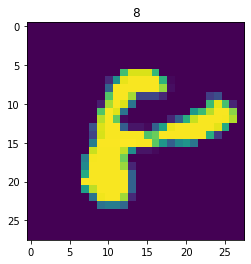

In [70]:
i = np.random.randint(X.shape[0])
fig,ax = plt.subplots()
ax.imshow(X[i])
ax.set_title(y[i])

## Extract

This step addresses the task of reading your dataset and passing it to the Dataset object. There are six different input methods available which are detailed in the [docs](https://www.tensorflow.org/guide/data#reading_input_data). When your dataset can be fully loaded into memory, it can be converted to a tensor and passed directly to the object.

In [72]:
dataset = tf.data.Dataset.from_tensor_slices((X,y))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.uint8, tf.uint8)>

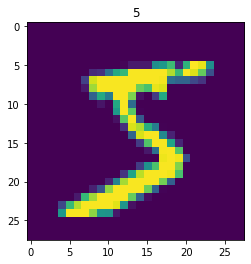

In [74]:
for im,label in dataset.take(1):
    fig,ax = plt.subplots()
    ax.imshow(im)
    ax.set_title(label.numpy())

## Transform

At this stage we can perform any transformations to our data prior to training. This can be as simple as shuffling the dataset prior to retrieving batches or applying random rotations for data augmentation.

### Shuffle

The first step prior to passing data to a model for training is to shuffle the data such that the order in which the model receives the data is random. The function `dataset.shuffle` requires the arguement `buffer_size` which determines how many elements in the dataset are considered during random selection of each point. For perfect shuffling, `buffer_size` should be the greater than or equal to the size of the dataset. However, this carries a significant memory burden so typiclly `buffer_size` is a fraction of the dataset size. 

In [75]:
dataset = dataset.shuffle(5000,seed=123,reshuffle_each_iteration=True)

### Augment

Finally, we augment the dataset by performing random transformations to each batch of samples. In order to to this, we revisit the transformation matrices discussed previously. When we initially discussed transformations, we used 2x2 matrices to rotate, reflect, etc a 2D image. For dataset augmentation, we also want to translate the image such that it is shifted in 2D space away from its original center point. In order to do this, we will use a 3x3 matrix and consider each point $P(x,y) = \begin{bmatrix}x&y&1\end{bmatrix}$.

In order to translate point $P(x,y)$ by $(\delta x, \delta y)$, we multiply P by the translation matrix

$$
\begin{bmatrix}x & y & 1\end{bmatrix} \times
\begin{bmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    \delta x & \delta y & 1
\end{bmatrix}
=
\begin{bmatrix}x+\delta x & y+\delta y & 1\end{bmatrix}
$$

In order to apply random transformations to the dataset, we can use the `dataset.map` function which will apply any python function to each element in the dataset. First we will write a function to calculate a random transformation matrix that scales the data within the limits of a specified zoom range.

In [76]:
def compute_random_zoom(zoom_min, zoom_max):
    # Get random zoom values for x and y
    zx = np.random.uniform(low=zoom_min, high=zoom_max, size=[1])[0]
    zy = np.random.uniform(low=zoom_min, high=zoom_max, size=[1])[0]

    # Build the matrix
    matrix = [[zx,0,0],[0,zy,0],[0,0,1]]
    return np.array(matrix)

This function relies on numpy to build the random transformation matrix. It could instead be written with tensorflow backend functions which will be faster than the respective numpy functions.

In [112]:
m = compute_random_zoom(0.5, 2)
m

array([[1.80131298, 0.        , 0.        ],
       [0.        , 1.67630283, 0.        ],
       [0.        , 0.        , 1.        ]])

To apply the transformation to an image, we will use the tensorflow_addon function `tfa.image.transform`. This function expects the transformation matrix to be a list of length 8. The function assumes that the ninth value in the matrix (corresponding to the bottom right corner) is always 1. Additionally, the function supports various `fill_modes` which sets the value of points that fall outside of the boundaries of the input.

In [113]:
m = m.flatten()[0:8]
m

array([1.80131298, 0.        , 0.        , 0.        , 1.67630283,
       0.        , 0.        , 0.        ])

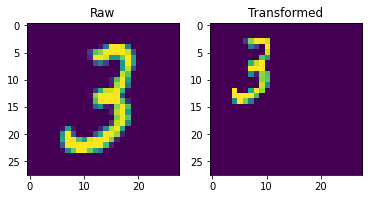

In [114]:
for im,label in dataset.take(1):
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(im)
    ax[0].set_title('Raw')
    ax[1].set_title('Transformed')

    imt = tfa.image.transform(im, m, fill_mode='constant', fill_value=0)
    ax[1].imshow(imt)

We are now ready to write an augmentation function that can be fed into `dataset.map`. The inputs for our new function should match the output of `dataset.take(1)` which in this case is a tuple with an X and y value.

In [102]:
def augment(*args):
    im = args[0]
    label = args[1]

    m = compute_random_zoom(0.5,2)
    m = m.flatten()[0:8]

    imt = tfa.image.transform(im, m, fill_mode='constant', fill_value=0)

    return imt,label

In [103]:
aug_dataset = dataset.map(augment)

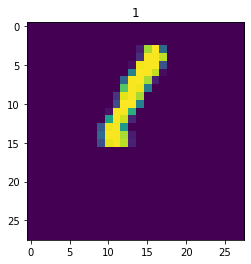

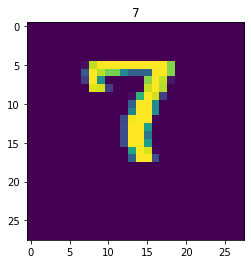

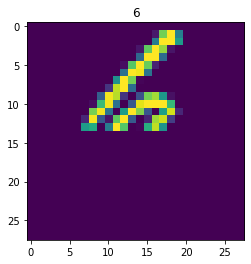

In [106]:
for im,label in aug_dataset.take(3):
    fig,ax = plt.subplots()
    ax.imshow(im)
    ax.set_title(label.numpy())

Next, the dataset is broken into batches for model training. The batch size determines how many datapoints are fed through a model before the model is updated.

In [ ]:
dataset = dataset.batch(20)

# Exercise
Try expanding the `augment` function to include at least one additional transformation such as rotation. Remember that you use the dot product of two matrices to combine two transformations into one.